# Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Load vqvae token data for each utt from disk

In [2]:
# Get list of token files in token dir
token_dir_path = '/Users/jonojace/GLE_samples/vqvae_group.43.upconv/vqvae_tokens'
files = os.listdir(token_dir_path)

# TODO Filter token files to get those wanted for analysis (certain speakers, certain number from each speaker)

# Create data structure to hold all token data and metadata
data = {}

for file in files:
    #get data from file
    with open(f'{token_dir_path}/{file}') as f:
        groups_and_atoms = f.read().split('\n') # on each line of file is <group_id>_<atom_id>
    groups = []
    for line in groups_and_atoms:
        group, _ = line.split('_')
        groups.append(int(group))
    #create entry for this file
    utt_id = os.path.basename(file)
    data[utt_id] = {
        'groups': groups
    }
    
assert len(data) == len(files)

print(f"Finished processing {len(data)} vqvae token files")

Finished processing 11653 vqvae token files


# Load codebook/embeddings from disk and calculate group centres

In [3]:
################################################################
# load embeddings matrix from disk
embeddings0 = torch.load('/Users/jonojace/GLE_samples/vqvae_group.43.upconv/embeddings/vqvae_codebook.pt', map_location='cpu')
embeddings0 = embeddings0.squeeze().numpy()
N_atoms, embedding_dim = embeddings0.shape

################################################################
# get group labels for each atom
    # first N_atoms_per_group atoms are group 0
    # second N_atoms_per_group atoms are group 1
        # etc. 
N_groups = 41
N_atoms_per_group = 10
assert (N_groups * N_atoms_per_group) == N_atoms
groups_for_atoms = []
for i in range(N_groups):
    groups_for_atoms.extend(N_atoms_per_group * [i])

################################################################
# create pandas dataframe from numpy array for atoms embeddings
df = pd.DataFrame({
    'type':'atom',
    'group': groups_for_atoms,
})
for i in range(embedding_dim):
    df[f'embedding_dim{i+1}'] = embeddings0[:,i]

In [4]:
################################################################
# calculate group centres
group_centres = []
for i in range(N_groups):
    # get the embeddings for atoms in group i
    group_embeddings = df[df['group'] == i].loc[:, 'embedding_dim1':f'embedding_dim{embedding_dim}']

    # get mean (group centre)
    group_centre = np.mean(group_embeddings).to_numpy()
    group_centres.append(group_centre)
    
# create [num_groups, num_dims] np array from the list of subarrays
group_centres = np.stack(group_centres, axis=0)

# Create temp dataframe for group centres so we can append to atoms dataframe
temp_df = pd.DataFrame({
        'type': 'group',
        'group': range(N_groups),
})
for i in range(embedding_dim):
    temp_df[f'embedding_dim{i+1}'] = group_centres[:,i]
    
# append group centres df to atoms df
df = df.append(temp_df)

In [5]:
df.head()

,type,group,embedding_dim1,embedding_dim2,embedding_dim3,embedding_dim4,embedding_dim5,embedding_dim6,embedding_dim7,embedding_dim8,...,embedding_dim119,embedding_dim120,embedding_dim121,embedding_dim122,embedding_dim123,embedding_dim124,embedding_dim125,embedding_dim126,embedding_dim127,embedding_dim128
0,atom,0,0.041744,0.159189,0.039837,-0.011334,-0.066680,0.035506,-0.109268,0.035948,...,-0.006712,-0.056668,-0.054526,0.062438,0.042738,-0.040919,0.012478,0.135716,-0.022384,0.015778
1,atom,0,0.054953,-0.036421,0.033542,0.068255,0.018141,-0.017118,0.001800,0.011617,...,-0.003867,0.017119,-0.137735,0.061273,0.017004,-0.102596,0.008558,-0.046921,-0.069148,0.083623
2,atom,0,-0.060603,-0.035166,-0.027606,-0.032610,-0.046878,-0.089832,0.068404,-0.087058,...,-0.010816,-0.025464,0.080998,-0.057518,-0.027311,0.021132,-0.021804,-0.076310,0.006712,-0.053651
3,atom,0,0.013220,-0.059470,0.014368,0.059319,0.022596,-0.047265,0.035939,-0.029868,...,-0.035701,0.040846,-0.068032,0.043342,-0.040761,-0.061346,-0.007768,-0.042552,-0.060794,0.076614
4,atom,0,0.021387,-0.079884,-0.028961,0.104451,0.008419,0.023210,0.008350,-0.005389,...,0.042647,0.021063,-0.123622,-0.011645,0.025113,-0.117274,-0.039880,-0.109966,-0.078579,0.058656


In [6]:
df.tail()

,type,group,embedding_dim1,embedding_dim2,embedding_dim3,embedding_dim4,embedding_dim5,embedding_dim6,embedding_dim7,embedding_dim8,...,embedding_dim119,embedding_dim120,embedding_dim121,embedding_dim122,embedding_dim123,embedding_dim124,embedding_dim125,embedding_dim126,embedding_dim127,embedding_dim128
36,group,36,-0.068570,0.049040,0.011878,0.019837,0.010702,-0.015314,-0.058229,-0.034227,...,-0.038168,0.014630,0.008873,0.011785,-0.021472,0.011743,0.002007,0.007228,0.027210,-0.020000
37,group,37,-0.025523,0.014013,-0.001179,0.012344,-0.011836,-0.011556,0.034490,-0.040551,...,-0.022817,-0.033775,0.028508,-0.033030,-0.002975,0.030267,0.013061,0.035377,0.057287,-0.032599
38,group,38,0.026072,-0.005856,-0.003113,-0.008421,-0.020129,-0.006077,0.019371,0.026921,...,-0.033014,-0.019358,-0.028034,0.038347,0.009436,-0.010814,-0.009491,-0.021241,-0.061940,-0.003624
39,group,39,0.020306,-0.022454,-0.012581,0.023468,-0.004948,0.002639,-0.016338,0.008139,...,-0.016025,-0.030673,0.002796,0.031560,-0.020433,-0.039454,-0.042299,0.002684,-0.005051,-0.042199
40,group,40,-0.028558,-0.049054,-0.020583,0.031973,0.034010,0.014491,0.005572,-0.014743,...,-0.008139,0.000750,0.012229,-0.033101,-0.001549,-0.041374,0.001635,-0.015090,-0.035297,-0.003530


# Plots

### Vqvae codebook T-SNE plots

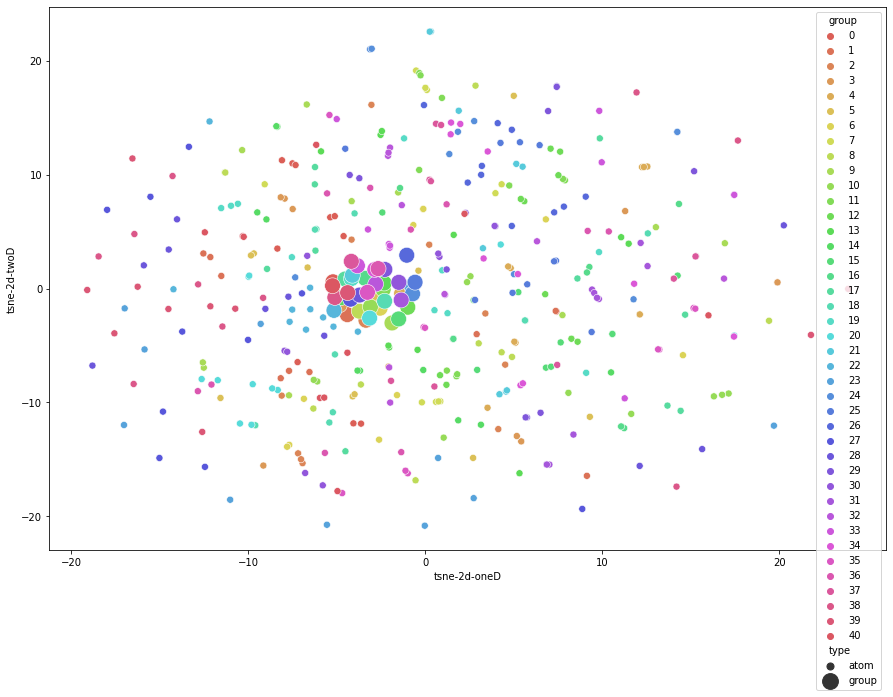

In [7]:
###############################################################
# fit T-SNE (with atom embeddings AND the group centres)
tsne = TSNE(n_components=2, verbose=False, perplexity=40, n_iter=300)
all_embeddings = df.loc[:,'embedding_dim1':f'embedding_dim{embedding_dim}']  # including centres
tsne_results = tsne.fit_transform(all_embeddings)

###############################################################
# assign T-SNE coords to their relevant dataframes
df['tsne-2d-oneD'] = tsne_results[:,0]
df['tsne-2d-twoD'] = tsne_results[:,1]

############################
# plot T-SNE for all atoms and all groups
scatter_plot_figsize = (15,10)
plt.figure(figsize=scatter_plot_figsize)

#TODO investigate how come sometimes when you fit T-SNE, some group centres are thrown way off from the rest???, sometimes they are not....

sns.scatterplot(
    x="tsne-2d-oneD", y="tsne-2d-twoD",
    hue="group",
    palette=sns.color_palette("hls", 41),
    data=df,
    alpha=1,
    size='type',
    sizes=(250, 50)
)
plt.show()

In [8]:
df.loc[df['group']==0,'embedding_dim1':f'embedding_dim{embedding_dim}']

,embedding_dim1,embedding_dim2,embedding_dim3,embedding_dim4,embedding_dim5,embedding_dim6,embedding_dim7,embedding_dim8,embedding_dim9,embedding_dim10,...,embedding_dim119,embedding_dim120,embedding_dim121,embedding_dim122,embedding_dim123,embedding_dim124,embedding_dim125,embedding_dim126,embedding_dim127,embedding_dim128
0,0.041744,0.159189,0.039837,-0.011334,-0.066680,0.035506,-0.109268,0.035948,-0.138182,0.025359,...,-0.006712,-0.056668,-0.054526,0.062438,0.042738,-0.040919,0.012478,0.135716,-0.022384,0.015778
1,0.054953,-0.036421,0.033542,0.068255,0.018141,-0.017118,0.001800,0.011617,-0.039221,-0.104983,...,-0.003867,0.017119,-0.137735,0.061273,0.017004,-0.102596,0.008558,-0.046921,-0.069148,0.083623
2,-0.060603,-0.035166,-0.027606,-0.032610,-0.046878,-0.089832,0.068404,-0.087058,0.010629,0.088844,...,-0.010816,-0.025464,0.080998,-0.057518,-0.027311,0.021132,-0.021804,-0.076310,0.006712,-0.053651
3,0.013220,-0.059470,0.014368,0.059319,0.022596,-0.047265,0.035939,-0.029868,0.000681,-0.092279,...,-0.035701,0.040846,-0.068032,0.043342,-0.040761,-0.061346,-0.007768,-0.042552,-0.060794,0.076614
4,0.021387,-0.079884,-0.028961,0.104451,0.008419,0.023210,0.008350,-0.005389,-0.040104,-0.145843,...,0.042647,0.021063,-0.123622,-0.011645,0.025113,-0.117274,-0.039880,-0.109966,-0.078579,0.058656
5,-0.032249,-0.099048,-0.102487,0.069714,-0.009576,0.021388,0.069668,-0.076127,0.027779,-0.110588,...,-0.014472,0.029665,-0.014623,-0.068126,-0.056916,-0.026998,-0.074963,-0.074356,-0.060639,0.023078
6,0.082861,0.171871,0.081010,-0.040624,-0.044763,-0.027955,-0.112563,0.044779,-0.100639,0.037900,...,-0.040500,-0.027996,-0.092709,0.121773,0.030442,-0.015495,0.030184,0.136908,-0.062417,0.087836
7,0.006181,0.115070,0.008720,0.027193,-0.011707,0.006312,-0.112035,0.003392,-0.076764,-0.087198,...,0.046615,-0.009581,-0.086410,0.023903,0.016931,-0.020556,-0.042144,0.016648,-0.076973,0.089468
8,-0.017730,0.068958,0.025619,-0.066926,-0.069228,-0.103334,0.018962,-0.046551,-0.041607,0.151652,...,-0.028528,-0.075692,0.066127,0.001624,0.010722,0.037829,0.030253,0.003294,0.020475,-0.051356
9,0.026064,0.137655,0.053494,-0.043593,-0.097167,-0.068556,-0.044972,0.007343,-0.118458,0.151289,...,-0.049471,-0.066167,0.038389,0.061470,0.028136,0.015251,0.049453,0.103155,0.018337,-0.028655


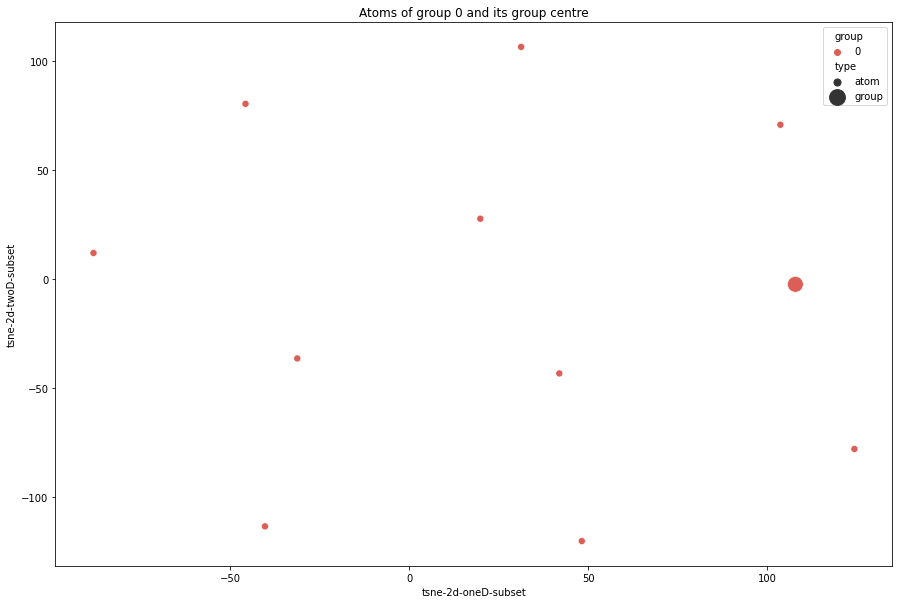

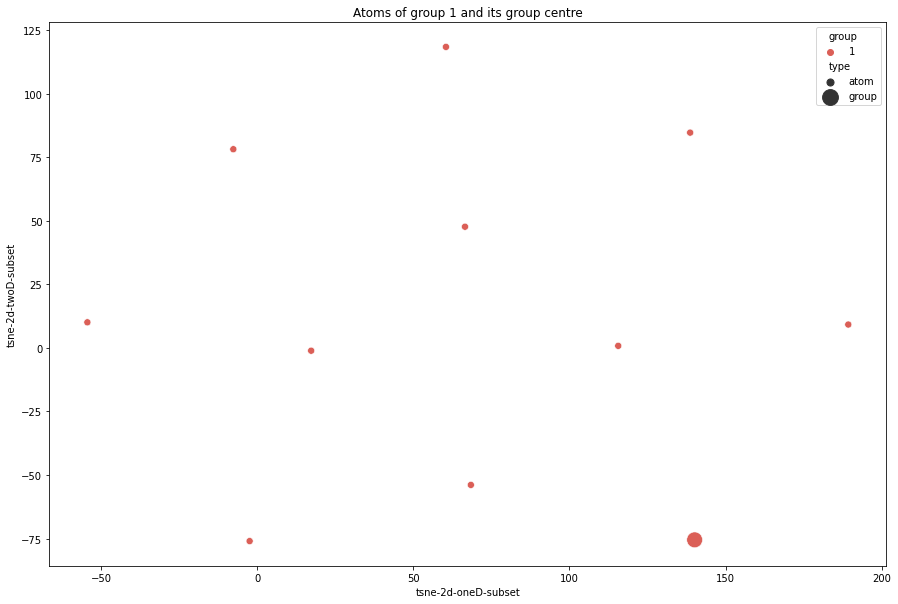

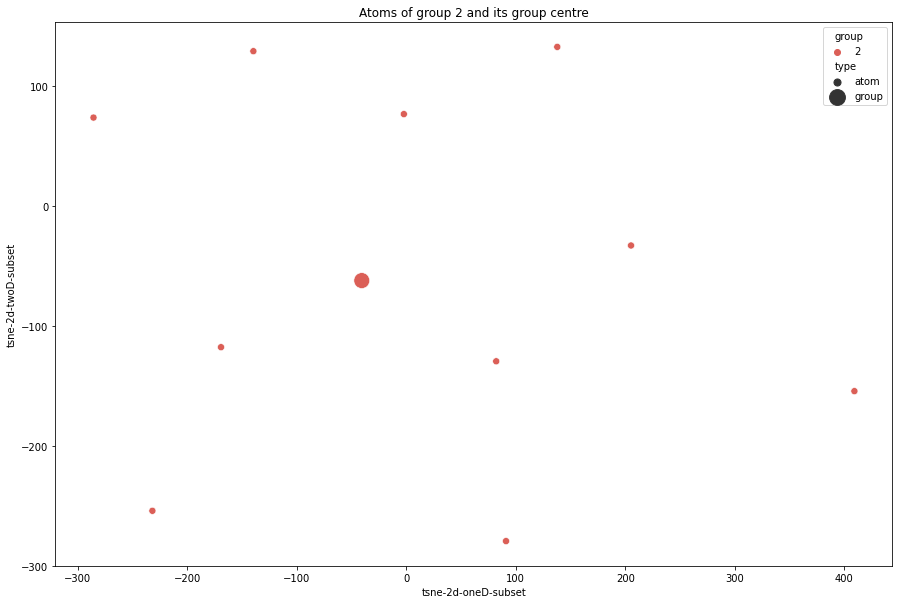

In [9]:
############################
# plot T-SNE for each atom in a single group 
# (also plotting group averaged centre)
N_groups_to_plot = 3

# iterate over each group
for i in range(N_groups_to_plot):
    plt.figure(figsize=scatter_plot_figsize)
    
    # refit T-SNE for each group and its centre
    all_embeddings = df.loc[:,'embedding_dim1':f'embedding_dim{embedding_dim}']  # including centres
    tsne_results = tsne.fit_transform(df.loc[df['group']==i,'embedding_dim1':f'embedding_dim{embedding_dim}'])
    
    df.loc[df['group']==i,'tsne-2d-oneD-subset'] = tsne_results[:,0]
    df.loc[df['group']==i,'tsne-2d-twoD-subset'] = tsne_results[:,1]

    #plot group centres
    sns.scatterplot(
        x="tsne-2d-oneD-subset", y="tsne-2d-twoD-subset",
        hue="group",
        palette=sns.color_palette("hls", 1),
        data=df[df['group']==i],
        alpha=1,
        size='type',
        sizes=(250, 50)
    )
    plt.title(f"Atoms of group {i} and its group centre")
    plt.show()

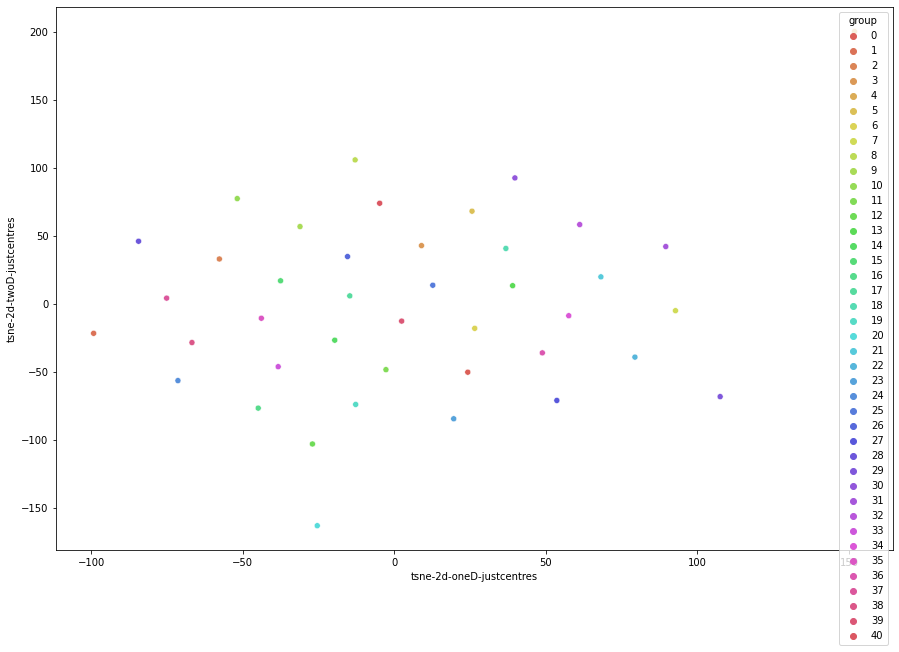

In [10]:
############################
# Plot a T-SNE fit of just the 41 group centres

###############################################################
# fit T-SNE (with atom embeddings AND the group centres)
all_embeddings = df.loc[df['type']=='group','embedding_dim1':f'embedding_dim{embedding_dim}']  # just centres
tsne_results = tsne.fit_transform(all_embeddings)

###############################################################
# assign T-SNE coords to their relevant dataframes
df.loc[df['type']=='group','tsne-2d-oneD-justcentres'] = tsne_results[:,0]
df.loc[df['type']=='group','tsne-2d-twoD-justcentres'] = tsne_results[:,1]

############################
# plot T-SNE for all atoms and all groups
scatter_plot_figsize = (15,10)
plt.figure(figsize=scatter_plot_figsize)

#TODO investigate how come sometimes when you fit T-SNE, some group centres are thrown way off from the rest???, sometimes they are not....

sns.scatterplot(
    x="tsne-2d-oneD-justcentres", y="tsne-2d-twoD-justcentres",
    hue="group",
    palette=sns.color_palette("hls", 41),
    data=df.loc[df['type']=='group'],
    alpha=1,
#     size='type',
#     sizes=(250, 50)
)
plt.show()

### Investigate whether the model is actually doing quantisation or not...

In [11]:
# Plot 'discrete' embeddings that are actually used by the decoder
# (you suspect they are not actually discrete and depend on encoder output)
discrete = torch.load('/Users/jonojace/GLE_samples/vqvae_group.43.upconv/decoder_input_vectors/p225_001.pt', map_location='cpu')
discrete = discrete.squeeze()

In [120]:
# Verify that if symbol is same, discrete embedding is the same
discrete.shape

discrete[0] == discrete[1] #first and second frames are silence, should be same vector

torch.eq(discrete[0], discrete[1])

torch.all(discrete[0] == discrete[1])

tensor(True)

In [122]:
unique_vectors, counts = torch.unique(discrete, dim=0, sorted=False, return_counts=True)
unique_vectors.shape[0] # this is the number of unique vectors in just the first utterance! should be equal to 41!!! the total number of groups

481

In [62]:
counts # shows that all but one vectors only occur once! apart from silence vector, thus model is not performing discretisation/quantisation

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1, 

In [123]:
print(unique_vectors[counts == 77]) #confirmed it is silence vector!
print(discrete[0])

tensor([[ 0.0658,  0.0335,  0.0120,  0.0147,  0.0179, -0.0115, -0.0208,  0.0617,
         -0.0176,  0.0128, -0.0060,  0.0874, -0.0203, -0.0228, -0.0791, -0.0049,
         -0.0422,  0.0038,  0.0774, -0.0038,  0.0371, -0.0008,  0.0023,  0.0021,
          0.0075,  0.0248,  0.0043, -0.0250,  0.0736, -0.0208,  0.0010, -0.0089,
         -0.0301, -0.0258, -0.0131,  0.0148, -0.0116,  0.0175, -0.0040, -0.0126,
          0.0157, -0.0379, -0.0489, -0.0489, -0.0167, -0.0025,  0.0299,  0.0588,
         -0.0388, -0.0119, -0.0425,  0.0268,  0.0168, -0.0397, -0.0382, -0.0910,
         -0.0067, -0.0111,  0.0027, -0.0162,  0.0046, -0.0091, -0.0425, -0.0148,
         -0.0070,  0.0148, -0.0324,  0.0160, -0.0148,  0.0258, -0.0604,  0.0242,
         -0.0135,  0.0276,  0.0306, -0.0194,  0.0564,  0.0282,  0.0201, -0.0238,
         -0.0039, -0.0033,  0.0400, -0.0283,  0.0151, -0.0348, -0.0002,  0.0099,
         -0.0808,  0.0445, -0.0011,  0.0398, -0.0524, -0.0037, -0.0190,  0.0197,
          0.0313,  0.0018, -

In [70]:
torch.all(unique_vectors[counts == 77].squeeze() == discrete[0])

tensor(True)

In [83]:
#compare distribution of vectors fed to decoder with distribution of discrete symbols

symbol_counter = Counter(data['p225_001.txt']['groups'])
symbol_counter.most_common()

[(12, 105),
 (17, 39),
 (26, 21),
 (14, 20),
 (37, 19),
 (29, 18),
 (13, 18),
 (1, 18),
 (2, 17),
 (34, 16),
 (40, 16),
 (7, 15),
 (8, 15),
 (35, 15),
 (18, 14),
 (19, 14),
 (3, 13),
 (0, 13),
 (20, 13),
 (11, 11),
 (16, 11),
 (32, 11),
 (36, 11),
 (4, 11),
 (25, 10),
 (9, 10),
 (10, 10),
 (5, 9),
 (31, 9),
 (33, 9),
 (24, 7),
 (6, 6),
 (15, 5),
 (21, 4),
 (30, 4)]

In [108]:
# create data structure so u can easily see which vectors belong to which symbol
from collections import defaultdict
group2vectors = defaultdict(list)
discrete.size()
assert discrete.size()[0] == len(data['p225_001.txt']['groups'])

for i in range(len(data['p225_001.txt']['groups'])):
    group2vectors[data['p225_001.txt']['groups'][i]].append(discrete[i])
    

In [109]:
len(group2vectors) # num of unique groups witnessed in utt 1

35

In [113]:
group2vectors.keys()

dict_keys([12, 25, 34, 15, 11, 7, 26, 8, 40, 37, 16, 3, 14, 5, 29, 18, 17, 31, 13, 9, 10, 35, 21, 0, 19, 33, 2, 32, 36, 24, 4, 6, 20, 1, 30])

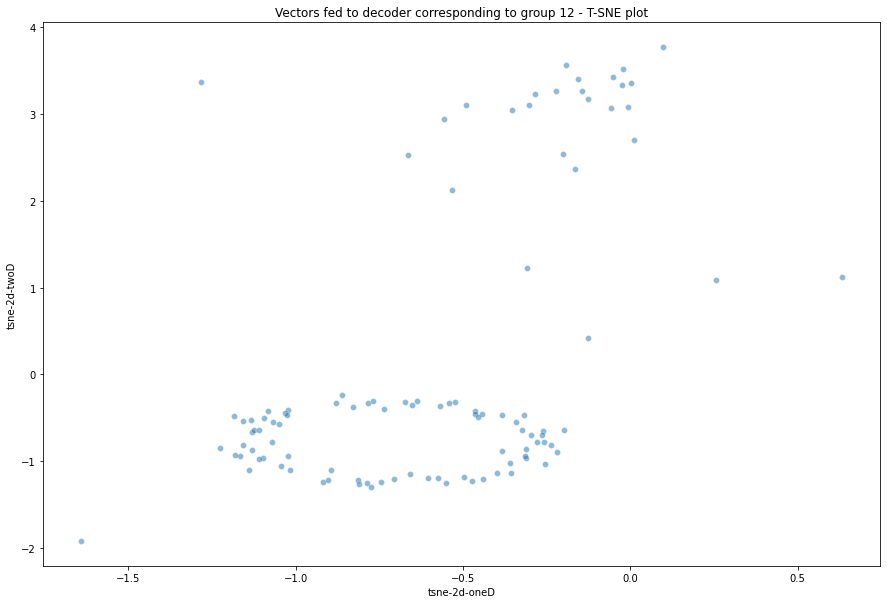

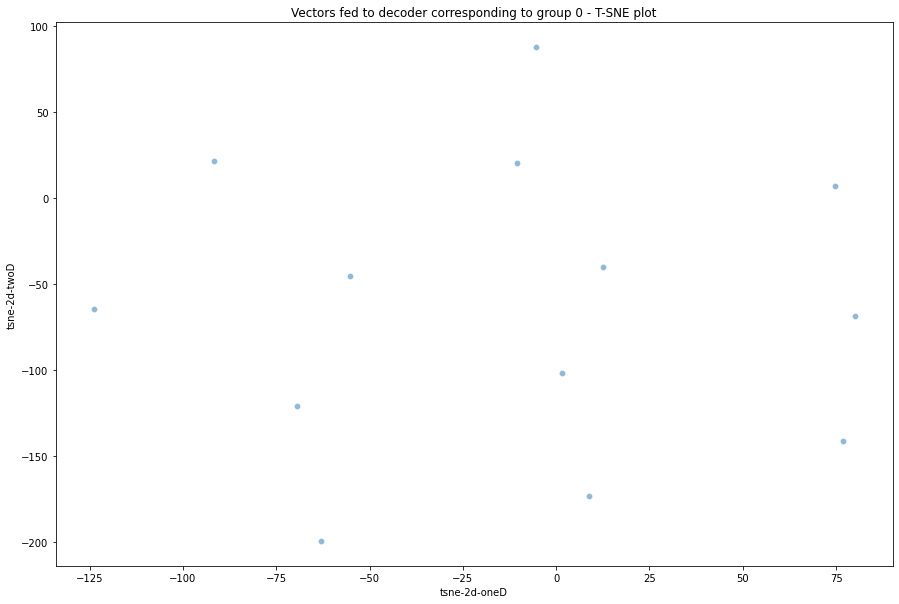

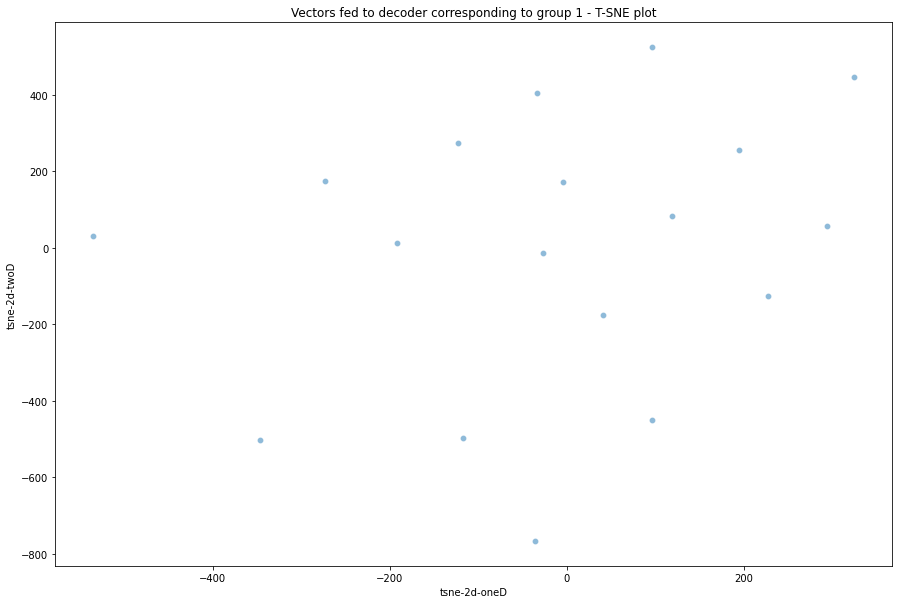

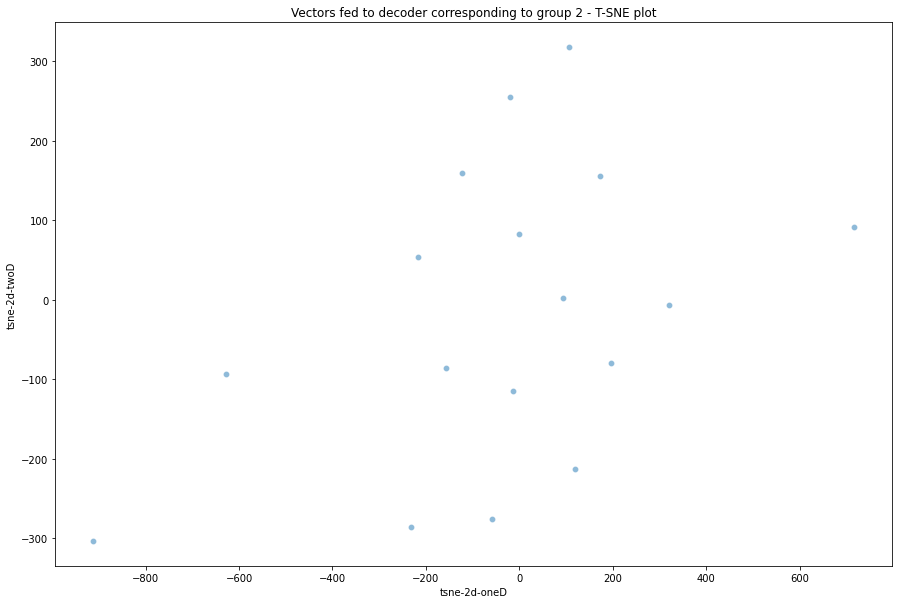

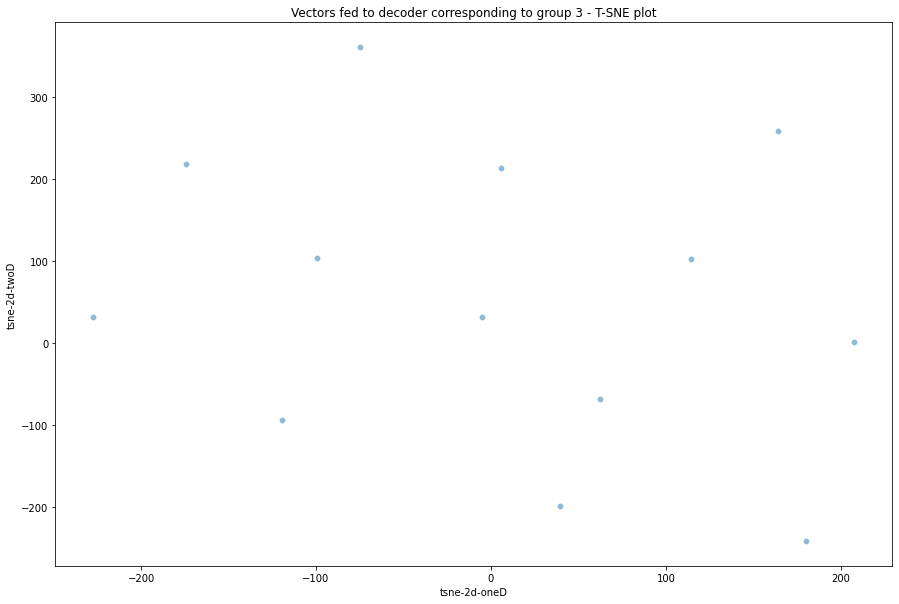

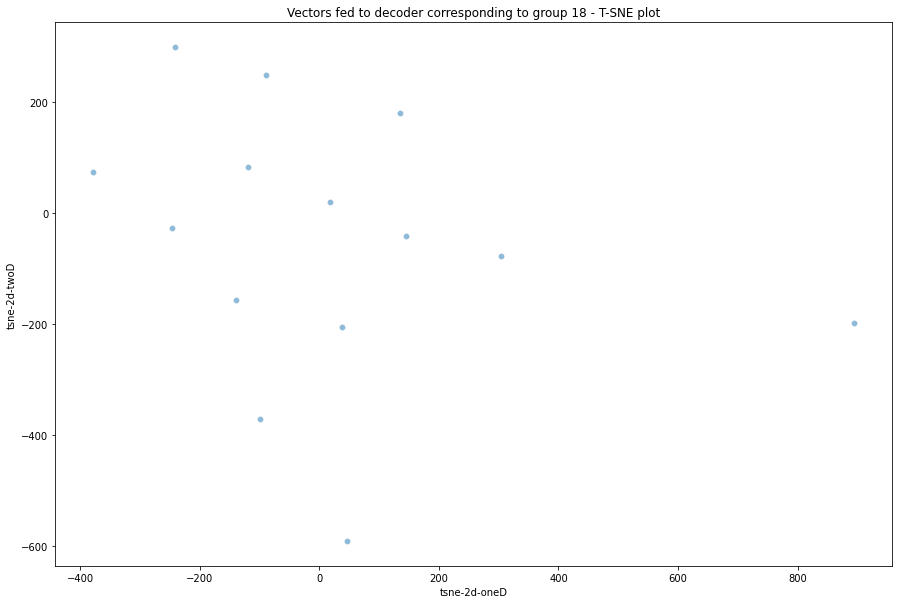

In [117]:
#plot for each group, the discretes that have been associated with it

groups_to_plot = [
    12, #silence
    0, 1, 2, 
    3, #outlier, due to encoder output causing large weight on far away atom?
    18 #outlier, due to encoder output causing large weight on far away atom?
]
# groups_to_plot = sorted(group2vectors.keys()) # all groups

scatter_plot_figsize = (15,10)

# NOTE if model is doing quantisation then each plot should be a SINGLE point
# not a cloud of points...
for i in groups_to_plot:
    tsne_results = tsne.fit_transform(torch.stack(group2vectors[i]))
    
    df = pd.DataFrame({
        'tsne-2d-oneD': tsne_results[:,0],
        'tsne-2d-twoD': tsne_results[:,1]
    })
    
    plt.figure(figsize=scatter_plot_figsize)

    sns.scatterplot(
        x="tsne-2d-oneD", y="tsne-2d-twoD",
        data=df,
        alpha=0.5,
    )
    plt.title(f"Vectors fed to decoder corresponding to group {i} - T-SNE plot")
    plt.show()

In [11]:
# plot how they evolve over duration of an utterance

In [12]:
# Generate discrete embeddings histogram for all utts in vctk, should only be 41 in total!!!

In [12]:
# create counter for embeddings, check for equality of 'discrete's

### Token frequency histograms

In [13]:
# count frequencies of groups
groups_c = Counter()
for utt_id in data:
    groups_c.update(data[utt_id]['groups'])
    
print("Most common groups")
for group, count in groups_c.most_common(5):
    print(f'\tGroup {group} - {count}')
    
print("\nLeast common groups")
for group, count in groups_c.most_common()[-5:]:
    print(f'\tGroup {group} - {count}')

Most common groups
	Group 12 - 1707617
	Group 34 - 566351
	Group 4 - 420587
	Group 26 - 414673
	Group 11 - 359594

Least common groups
	Group 9 - 190832
	Group 8 - 185925
	Group 30 - 170713
	Group 5 - 167902
	Group 3 - 147543


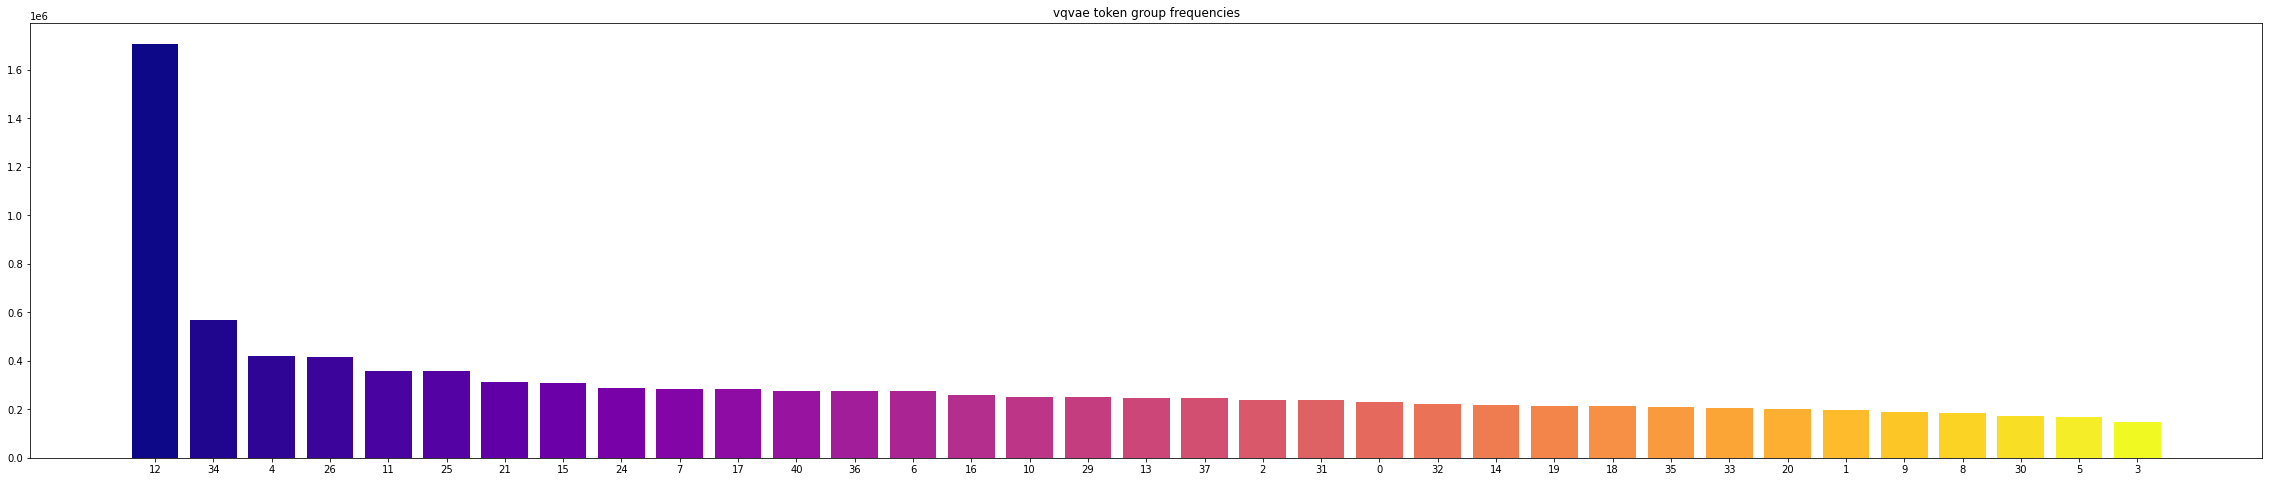

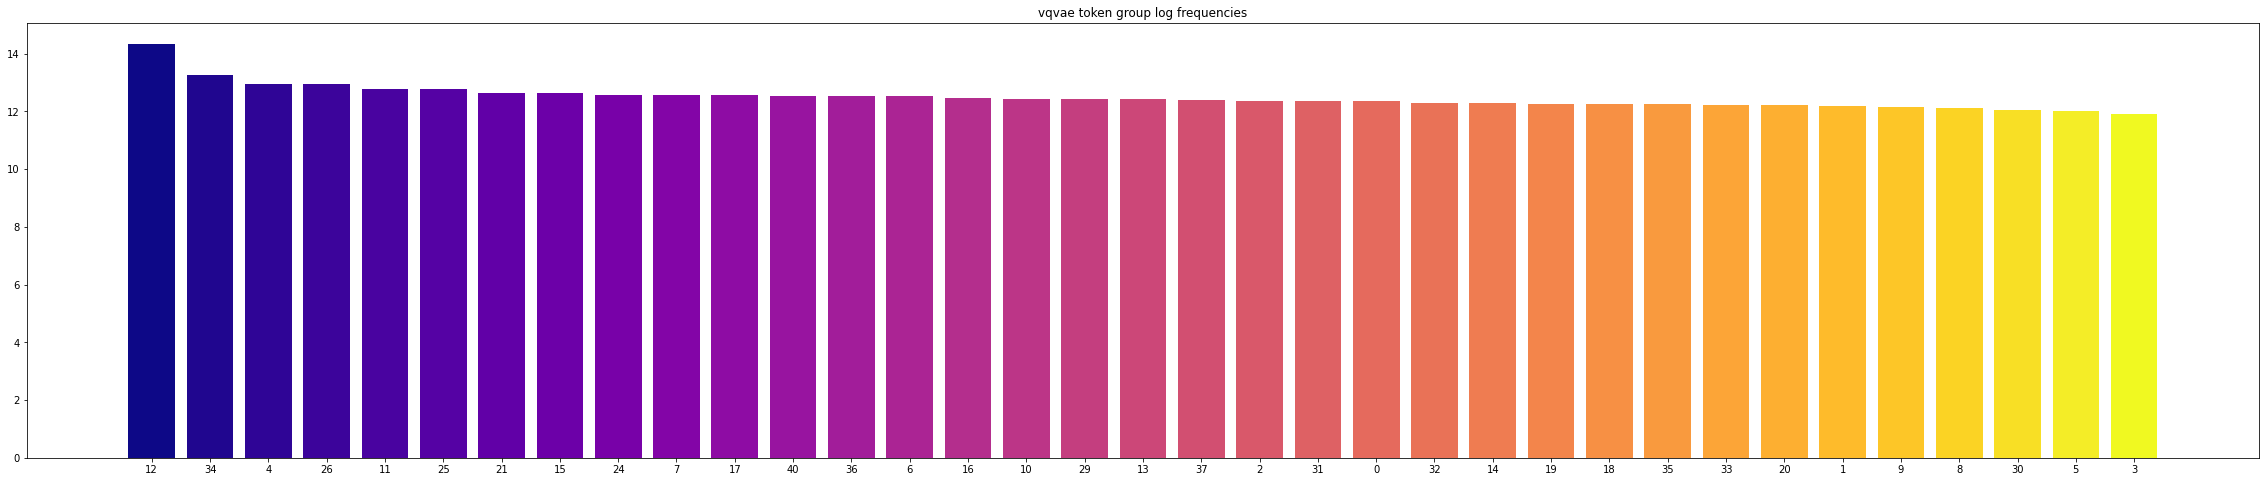

In [14]:
plt.rcParams['figure.figsize'] = [40, 8]

# Get equally spaced colors to assign to each group
total_N_groups = len(groups_c)
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('plasma')
# cmap = plt.get_cmap('rainbow')
# cmap = plt.get_cmap('gist_rainbow')
# cmap = plt.get_cmap('gist_ncar')
# print('Default number of colors in the lookup table:', len(cmap.colors)) # default: 256 colors
# print('First color:', cmap.colors[0])
# print('Last color:', cmap.colors[-1])
colors = cmap(np.linspace(0, 1, total_N_groups)).tolist() # get some equally spaced colors

# create mapping from group number to its color, colors are ordered by group freq
group2color = {}
for color, group in zip(colors, [group for group, count in groups_c.most_common()]):
    group2color[group] = color

def sorted_histogram(counter, token_type, title=None, morph_y_fn=None):
    N = len(counter)
    x = np.arange(N)
    x_labels = [str(key) for key, count in counter.most_common()]
    y = [count for key, count in counter.most_common()]
    
    # get color map 
    if token_type == 'groups':
         color_map = [group2color[int(group)] for group in x_labels]
    elif token_type == 'atoms':
         color_map = [group2color[atom2group[int(atom)]] for atom in x_labels]
    else:
         raise ValueError()
            
    # TODO add legend for color to group mapping
    
    if morph_y_fn:
        y = morph_y_fn(y)
        
    if title:
        plt.title(title)    
    
    plt.bar(x, y, color=color_map)
    plt.xticks(x, x_labels)
    plt.show()

sorted_histogram(groups_c, 'groups', title='vqvae token group frequencies')
# sorted_histogram(atoms_c, 'atoms', title='vqvae token atom frequencies') # TODO single big bar 

sorted_histogram(groups_c, 'groups', title='vqvae token group log frequencies', morph_y_fn=np.log)
# sorted_histogram(atoms_c, 'atoms', title='vqvae token atom log frequencies', morph_y_fn=np.log) 

# TODO plot atoms grouped with those atoms of same group, ranked by atom frequency, then finally ranked by group frequency
# e.g. group 12's 10 atoms ranked by atom frequency, then group 4's 10 atoms ranked by atom frequency, etc.... 

### Token id over time


Plots of groups over time SCATTER


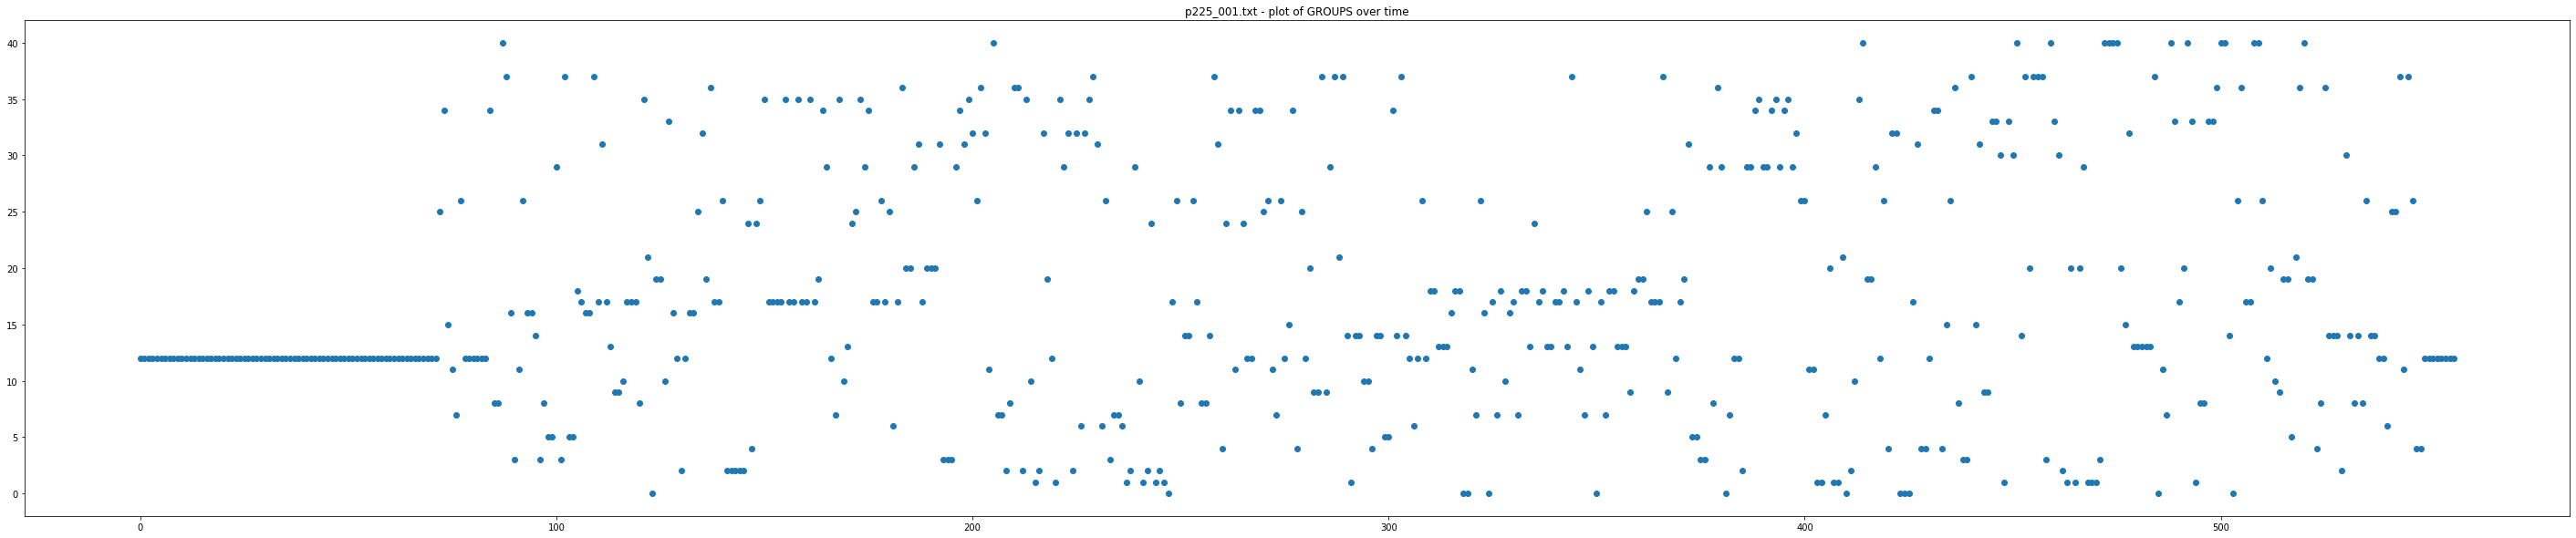

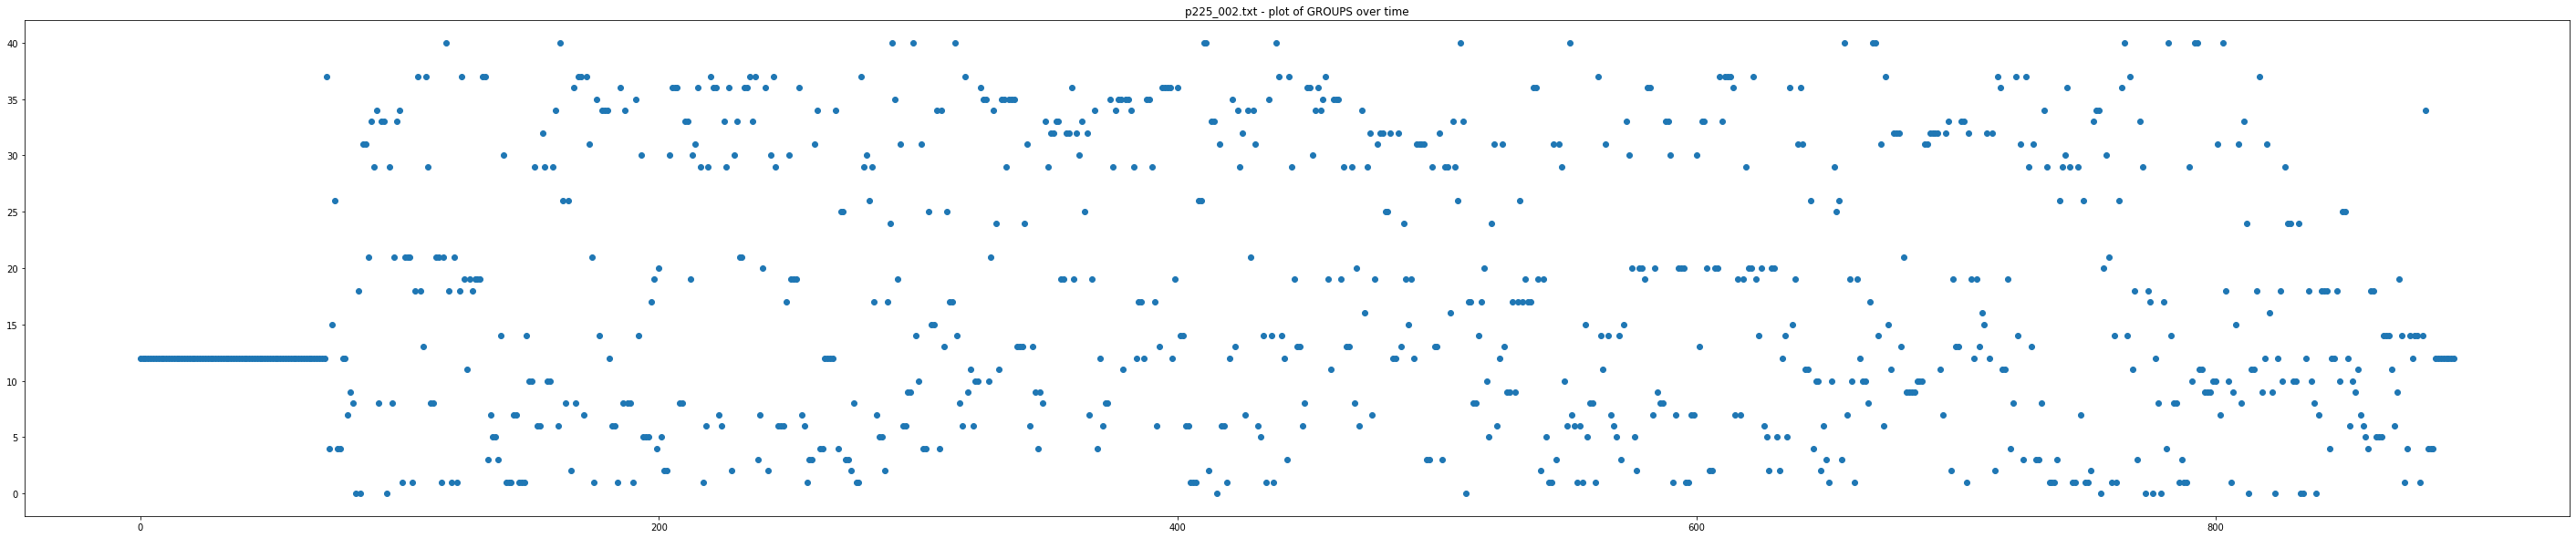

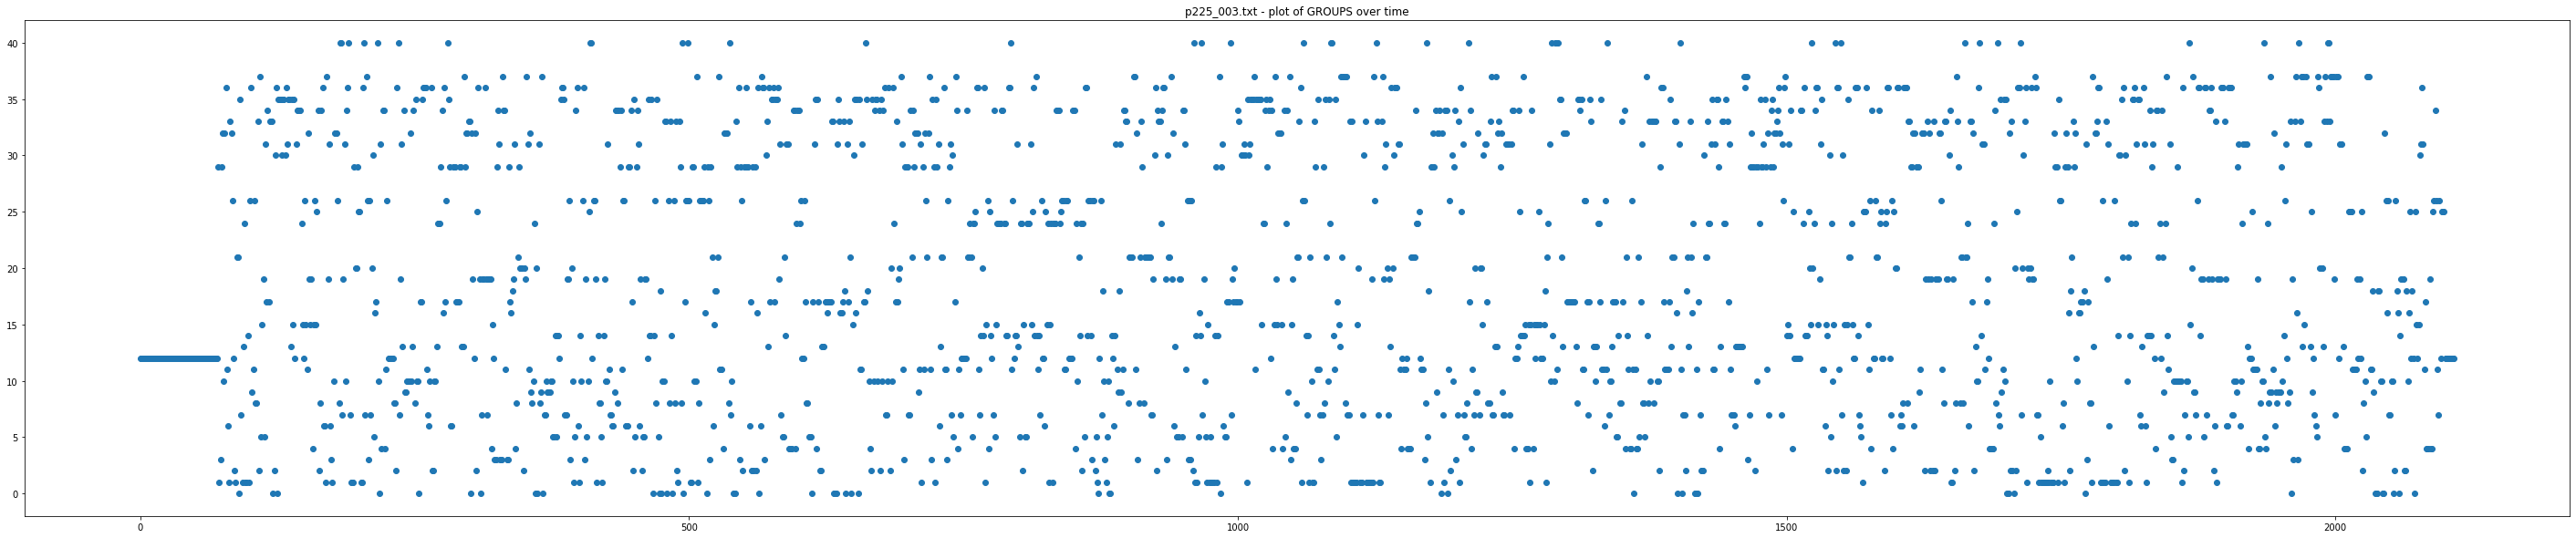


Plots of groups over time LINE


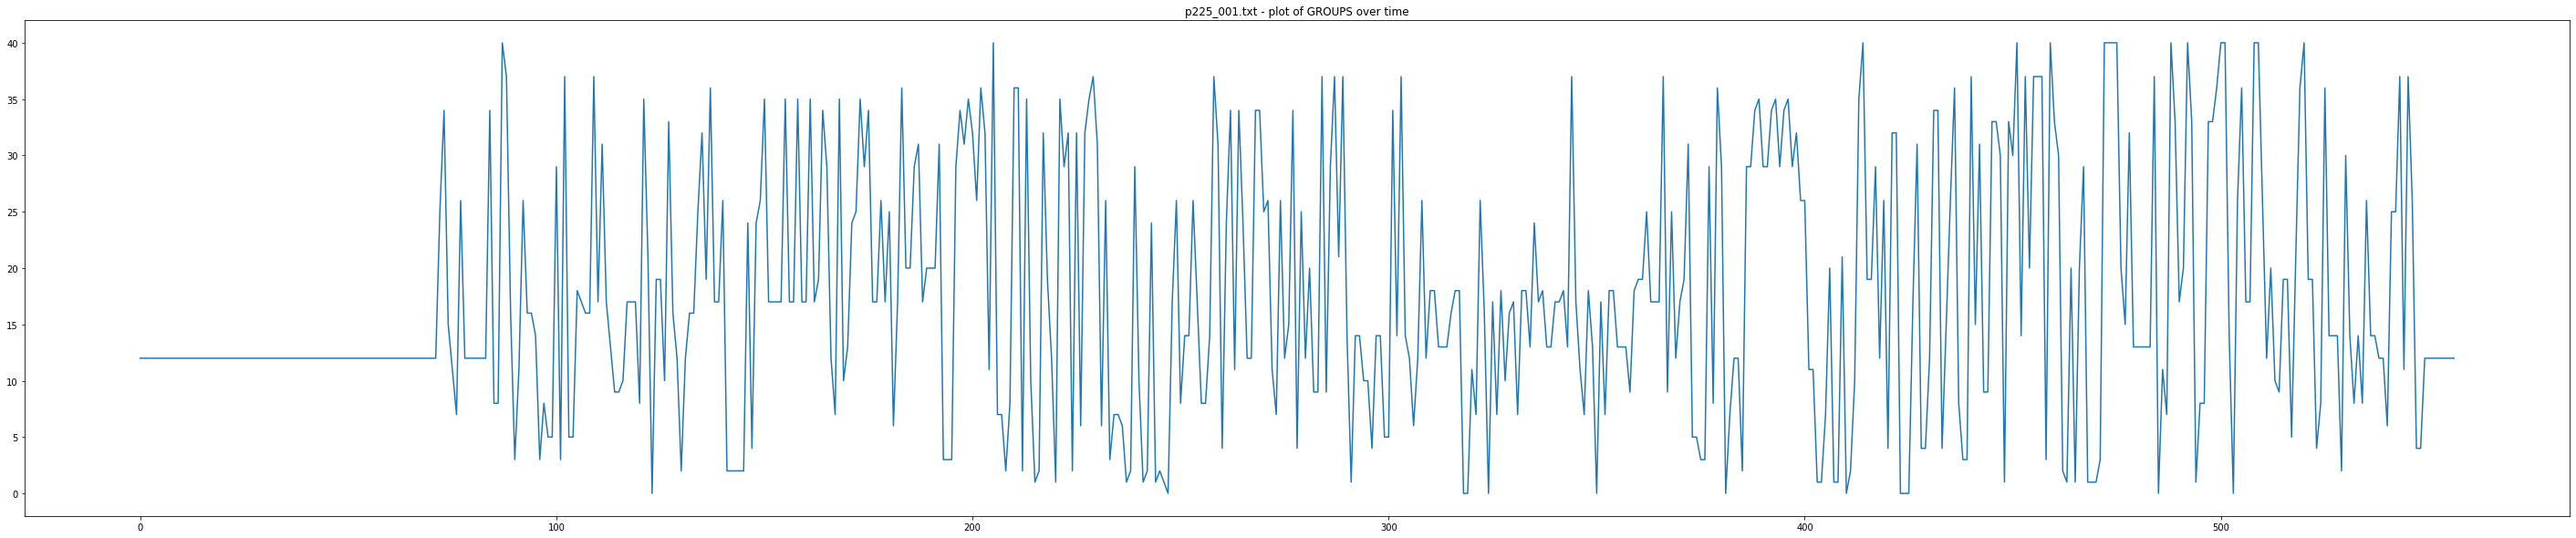

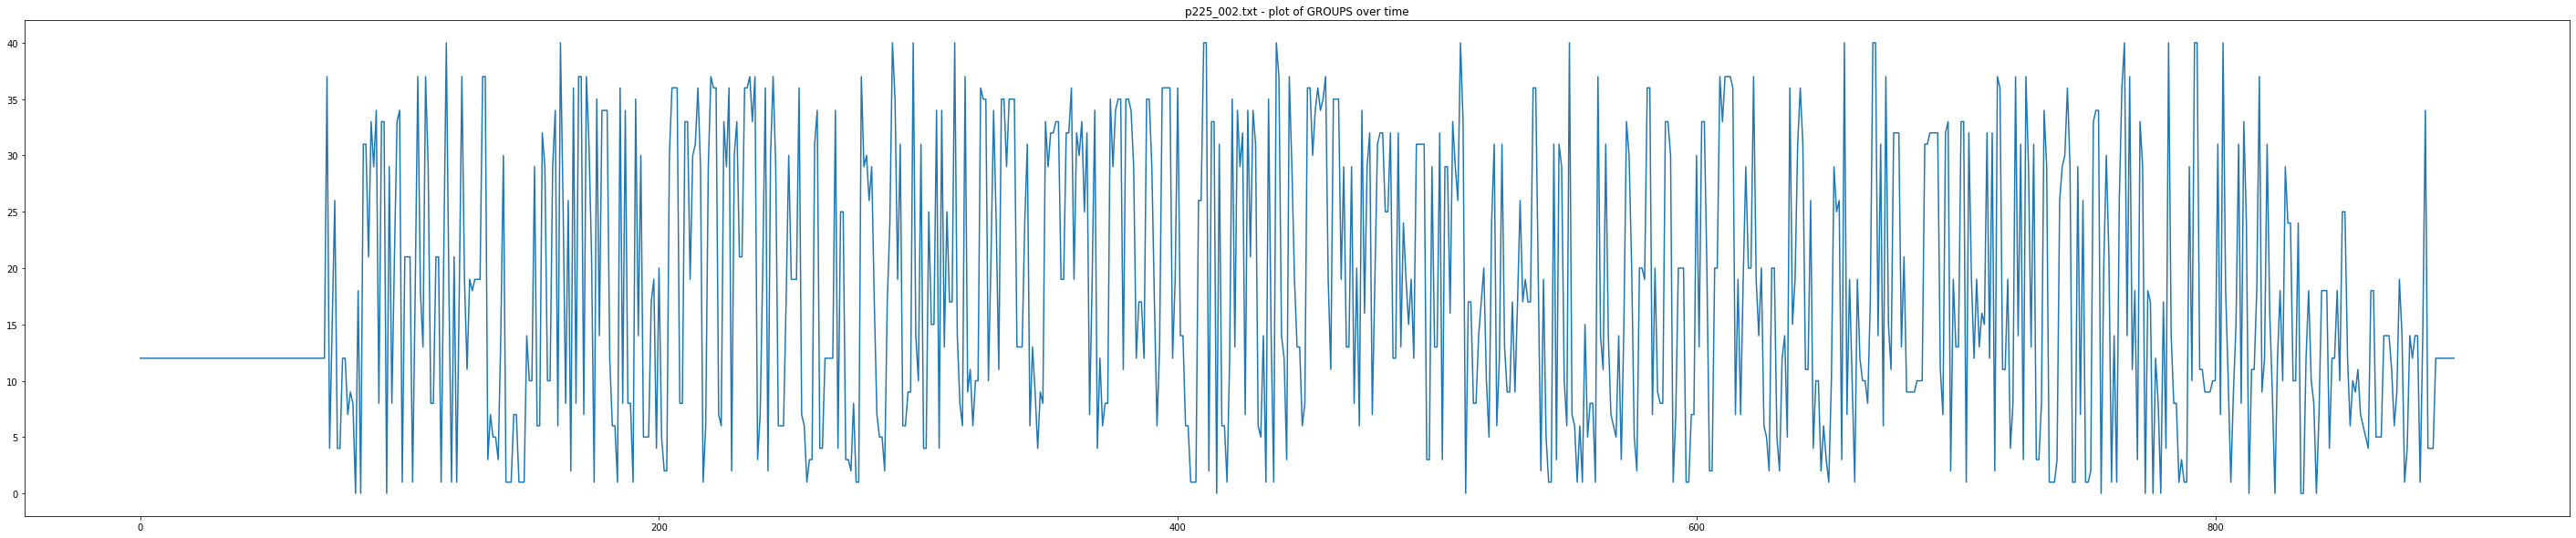

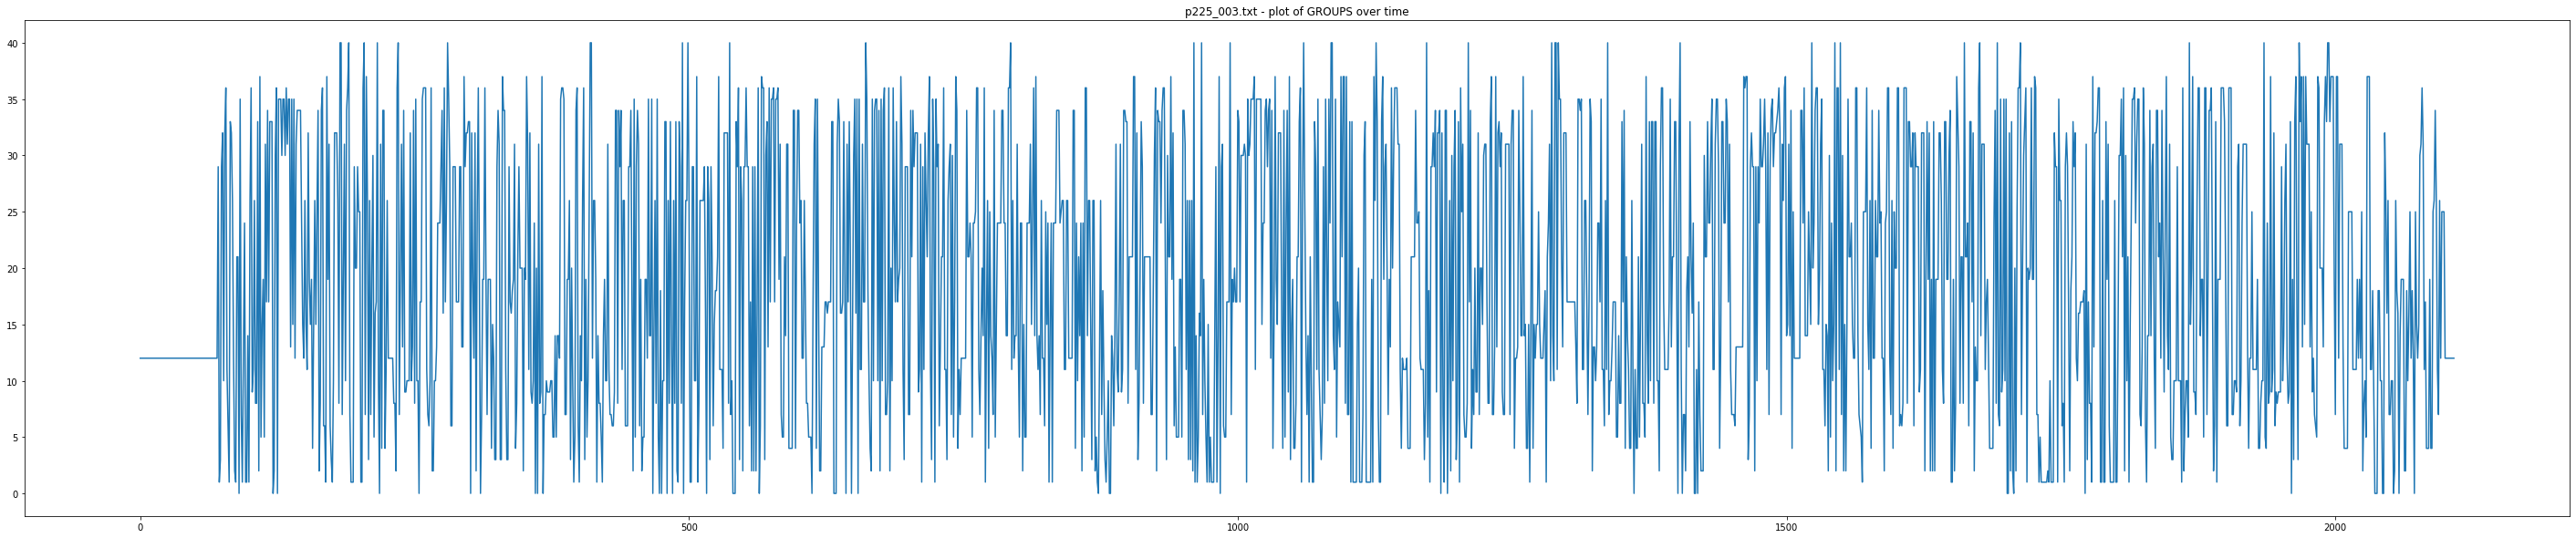

In [15]:
plt.rcParams['figure.figsize'] = [50, 10]

num_to_plot = 3

def plot_tokens_over_time(file, data_to_plot, plot_type='scatter'):
    y = data[file][data_to_plot]
    x = np.arange(len(y))
    plt.title(f"{file} - plot of {data_to_plot.upper()} over time")
    if plot_type == 'scatter':
        plt.scatter(x, y)
    elif plot_type == 'line':
        plt.plot(x, y) # this potentially shows that tokens fluctuate within a phone, so perhaps decoder uses combinations of tokens to to transmit more information
    else:
        raise ValueError
    plt.show()
    
sorted_files = sorted(data.keys())

#scatter plots
data_to_plot = 'groups'
print(f"\nPlots of {data_to_plot} over time SCATTER")
for file in sorted_files[:num_to_plot]:
    plot_tokens_over_time(file, data_to_plot, plot_type='scatter')
    
#line plots
data_to_plot = 'groups'
print(f"\nPlots of {data_to_plot} over time LINE")
for file in sorted_files[:num_to_plot]:
    plot_tokens_over_time(file, data_to_plot, plot_type='line')
    
# TODO color code the different groups